# 18.3 Gaussian Process Inference

# 18.3.1 Posterior Inference for Regression

In [5]:
import math
import os
!pip install gpytorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import optimize
from scipy.spatial import distance_matrix
from d2l import torch as d2l

d2l.set_figsize()

  Obtaining dependency information for gpytorch from https://files.pythonhosted.org/packages/12/24/805d9a4fcb5d105b95b2dac56d0764cfcceba31319437ca94a6592552f84/gpytorch-1.11-py3-none-any.whl.metadata
  Using cached gpytorch-1.11-py3-none-any.whl.metadata (7.4 kB)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/88/a3/023bf03411b8d89954d028dd56dc97f5fa04f18b4cb2acf4315dfb3dfa15/scikit_learn-1.3.1-cp39-cp39-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for linear-operator>=0.5.0 from https://files.pythonhosted.org/packages/4e/3b/c86ec0c226763a2a199b370f50309ef58c0d8c1555e6a278bd053263881f/linear_operator-0.5.2-py3-none-any.whl.metadata
  Using cached linear_operator-0.5.2-py3-none-any.whl.metadata (15 kB)
  Obtaining dependency information for jaxtyping>=0.2.9 from https://files.pythonhosted.org/packages/9a/ed/472785389fbbcf190671fc32f56c7323515bd931bd11e18426948cb3e509/jaxtyping-0.2.22-py3-none-any.whl.metadata
  Using 

# 18.3.2 Equations for Making Predictions and Learning Kernel Hyperparameters in GP Regression

# 18.3.3 Interpreting Equations for Learning and Predictions

# 18.3.4 Worked Example from Scratch

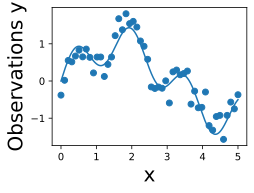

In [6]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig

sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_maker1(train_x, sig=sig), data_maker1(test_x, sig=0.)

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y)
d2l.plt.xlabel("x", fontsize=20)
d2l.plt.ylabel("Observations y", fontsize=20)
d2l.plt.show()

In [7]:
mean = np.zeros(test_x.shape[0])
cov = d2l.rbfkernel(test_x, test_x, ls=0.2)

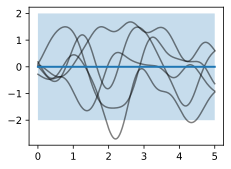

In [8]:
prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=5)
d2l.plt.plot(test_x, prior_samples.T, color='black', alpha=0.5)
d2l.plt.plot(test_x, mean, linewidth=2.)
d2l.plt.fill_between(test_x, mean - 2 * np.diag(cov), mean + 2 * np.diag(cov),
                 alpha=0.25)
d2l.plt.show()

In [9]:
ell_est = 0.4
post_sig_est = 0.5

def neg_MLL(pars):
    K = d2l.rbfkernel(train_x, train_x, ls=pars[0])
    kernel_term = -0.5 * train_y @ \
        np.linalg.inv(K + pars[1] ** 2 * np.eye(train_x.shape[0])) @ train_y
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1] ** 2 * \
                                         np.eye(train_x.shape[0])))
    const = -train_x.shape[0] / 2. * np.log(2 * np.pi)

    return -(kernel_term + logdet + const)


learned_hypers = optimize.minimize(neg_MLL, x0=np.array([ell_est,post_sig_est]),
                                   bounds=((0.01, 10.), (0.01, 10.)))
ell = learned_hypers.x[0]
post_sig_est = learned_hypers.x[1]

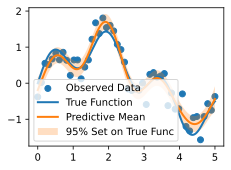

In [10]:
K_x_xstar = d2l.rbfkernel(train_x, test_x, ls=ell)
K_x_x = d2l.rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = d2l.rbfkernel(test_x, test_x, ls=ell)

post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ train_y
post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ K_x_xstar

lw_bd = post_mean - 2 * np.sqrt(np.diag(post_cov))
up_bd = post_mean + 2 * np.sqrt(np.diag(post_cov))

d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
d2l.plt.legend(['Observed Data', 'True Function', 'Predictive Mean', '95% Set on True Func'])
d2l.plt.show()

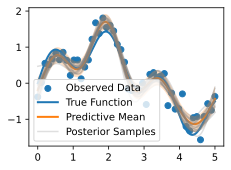

In [11]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
d2l.plt.scatter(train_x, train_y)
d2l.plt.plot(test_x, test_y, linewidth=2.)
d2l.plt.plot(test_x, post_mean, linewidth=2.)
d2l.plt.plot(test_x, post_samples.T, color='gray', alpha=0.25)
d2l.plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(['Observed Data', 'True Function', 'Predictive Mean', 'Posterior Samples'])
d2l.plt.show()

# 18.3.5 Making Life Easy with GPyTorch

In [12]:
# First let's convert our data into tensors for use with PyTorch
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [13]:
# Initialize Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()
# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [14]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
              f'squared lengthscale: '
              f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
              f'noise variance: {model.likelihood.noise.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 0.998 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.718 squared lengthscale: 0.496 noise variance: 0.312
Iter 21/50 - Loss: 0.479 squared lengthscale: 0.519 noise variance: 0.128
Iter 31/50 - Loss: 0.396 squared lengthscale: 0.511 noise variance: 0.059
Iter 41/50 - Loss: 0.411 squared lengthscale: 0.507 noise variance: 0.047


In [15]:
# Get into evaluation (predictive posterior) mode
test_x = torch.tensor(test_x)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

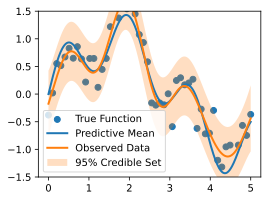

In [16]:
with torch.no_grad():
    # Initialize plot
    f, ax = d2l.plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower bounds for 95\% credible set (in this case, in
    # observation space)
    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy())
    ax.plot(test_x.numpy(), test_y.numpy(), linewidth=2.)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), linewidth=2.)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['True Function', 'Predictive Mean', 'Observed Data',
               '95% Credible Set'])

# 18.3.6 Summary